In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
df = pd.read_csv('diamonds.csv', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Data Analysis

In [3]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

**Note:** There are some categorical columns that we'll need to convert before training our model.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [5]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


**Note:** We do not have any missing values here but the columns 'x', 'y' and 'z', which correspond to the shape of the diamond, seem to have 0 values which does not seem like accurate values for a shape. Therefore we are going to remove those values for better accuracy and precision.

In [7]:
# Remove 0 values from the last three columns
df = df.drop(df.loc[df.x <= 0].index)
df = df.drop(df.loc[df.y <= 0].index)
df = df.drop(df.loc[df.z <= 0].index)

df.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [8]:
# Check for duplicates
df.duplicated().sum()

145

**Note:** We also have duplicates, so we're going to remove them.

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
# Set our response variable as the index of the dataframe
df = df.reindex(columns=['price', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'])

### Feature Encoding

In [11]:
# Convert categorical columns into numeric types 
df_cut = {'Fair':0,
               'Good':1,
               'Very Good':2, 
               'Premium':3,
               'Ideal':4}

df_color = {'J':0,
                 'I':1, 
                 'H':2,
                 'G':3,
                 'F':4,
                 'E':5,
                 'D':6}

df_clarity = {'I1':0,
                   'SI2':1,
                   'SI1':2,
                   'VS2':3,
                   'VS1':4,
                   'VVS2':5,
                   'VVS1':6,
                   'IF':7}

df.cut = df.cut.map(df_cut);
df.clarity = df.clarity.map(df_clarity);
df.color = df.color.map(df_color);
df.head()

,price,carat,cut,color,clarity,depth,table,x,y,z
1,326,0.23,4,5,1,61.5,55.0,3.95,3.98,2.43
2,326,0.21,3,5,2,59.8,61.0,3.89,3.84,2.31
3,327,0.23,1,5,4,56.9,65.0,4.05,4.07,2.31
4,334,0.29,3,1,3,62.4,58.0,4.20,4.23,2.63
5,335,0.31,1,0,1,63.3,58.0,4.34,4.35,2.75


### Data Visualization

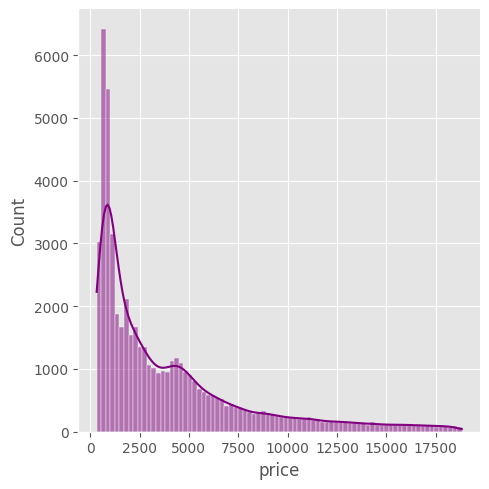

In [12]:
# Distribution of the 'Price' variable
plt.style.use('ggplot')
sns.displot(x='price', data=df, kde=True, color='purple');

**Note:** We can observe here that the distribution of the 'price' variable is right-skewed, as the mass of the distribution is concentrated on the left of the plot.

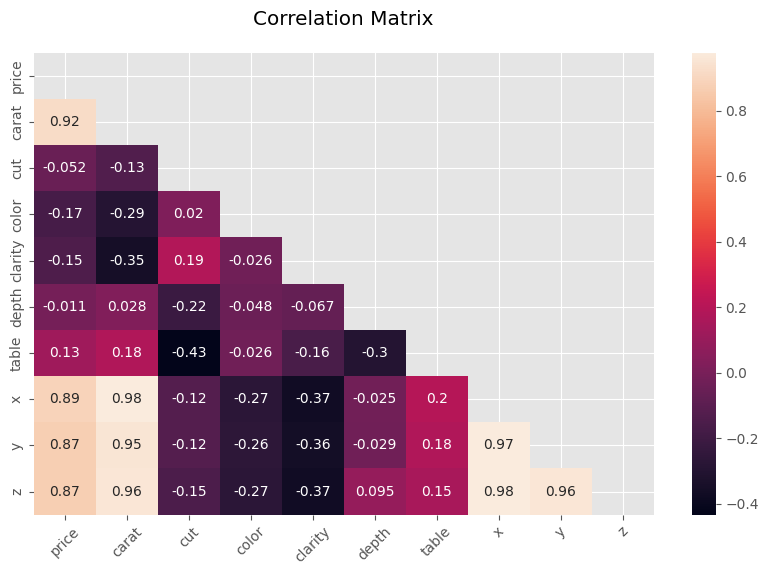

In [13]:
# Correlation matrix 
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10,6))
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Correlation Matrix', pad=20)
plt.xticks(rotation=45)
plt.show()

**Note:** The column 'price', our response variable, seems to be correlated with the 'carat' and shape ('x', 'y' and 'z') columns.

Text(0.5, 1.0, 'Carat vs Price')

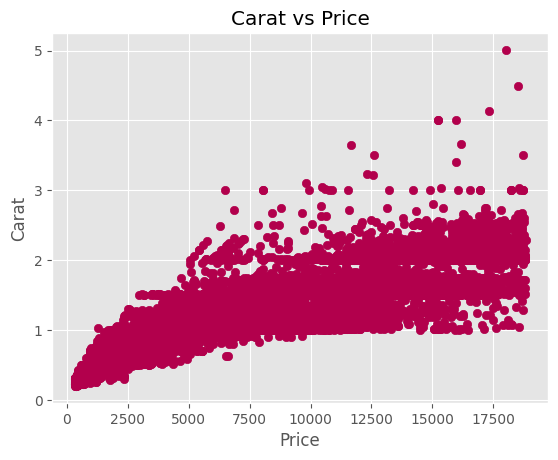

In [14]:
# Scatter plot to see the distribution of the 'price' variable vs. the 'carat' variable
plt.scatter(df['price'], df['carat'], c = '#b2004c')
plt.xlabel("Price")
plt.ylabel("Carat")
plt.title("Carat vs Price")

### Get a glimpse of a naive one-dimensional model with k = 1 by hand

In [15]:
# Get a subset of the data i.e. rows 3 to 10
# Use the 'carat' as the predictor
x_true = df.carat.iloc[3:10]

# Use the 'price' column as the response
y_true = df.price.iloc[3:10]

# Sort the data to get indices ordered from lowest to highest carat values
idx = np.argsort(x_true).values 

# Get the predictor data in the order given by idx above
x_true  = x_true.iloc[idx].values

# Get the response data in the order given by idx above
y_true  = y_true.iloc[idx].values

In [16]:
def find_nearest(array,value):
    
    # Use .idxmin() function on the series to find idx
    idx = pd.Series(np.abs(array-value)).idxmin()

    # Return the nearest neighbor index and value
    return idx, array[idx]

In [17]:
# Create some synthetic x-values (might not be in the actual dataset)
x = np.linspace(np.min(x_true), np.max(x_true))

# Initialize the y-values for the length of the synthetic x-values to zero
y = np.zeros((len(x)))

In [18]:
# Apply the KNN algorithm to predict the y-value for the given x value
for i, xi in enumerate(x):

    # Get the Sales values closest to the given x value
    y[i] = y_true[find_nearest(x_true, xi )[0]]

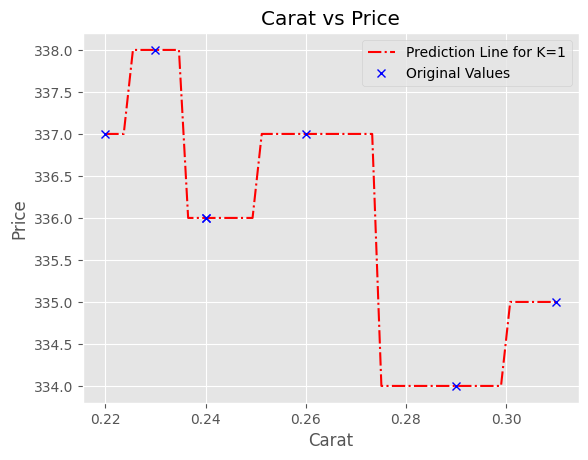

In [19]:
# Plot the synthetic data along with the predictions    
plt.plot(x, y, '-.', c='r')

# Plot the original data using black x's.
plt.plot(x_true, y_true, 'kx', c='b')

plt.title('Carat vs Price')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.legend(['Prediction Line for K=1', 'Original Values'])

**Note:** As we can see, the red curve corresponds interpolates, i.e. passes directly through the training data. It indicates that the predictions are far too variable, while a bigger value for K would surely fit much closer to f(X).

### Model Fitting

In [20]:
# Split data into training and test sets
X = df.drop(['price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [21]:
# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
# Build a naive KNN model with k=1
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Text(0, 0.5, 'y_test')

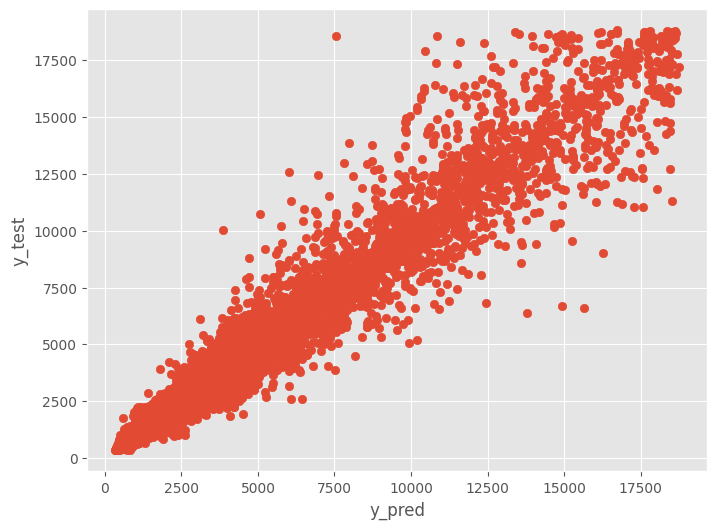

In [23]:
# Plot predictions vs original values
plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')

In [24]:
# Fit KNN models for K values ranging between 1 to 100
r2_scores=[]
mse_scores=[]

for i in range(1, 100):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2_scores.append(r2)
    mse_scores.append(mse)

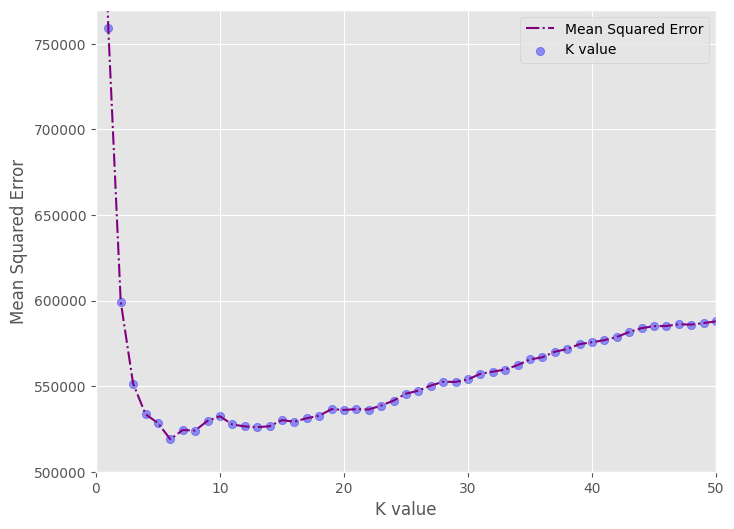

In [25]:
# Plot MSE for each K value
mse_scores.insert(0, 1000000)
plt.figure(figsize=(8,6))
plt.plot(mse_scores, '-.', c='purple')
plt.scatter(range(0, 100), y=mse_scores, alpha=0.4, c='b')
plt.xlabel("K value")
plt.ylabel("Mean Squared Error")
plt.xlim(0, 50)
plt.legend(['Mean Squared Error', 'K value'])
plt.ylim(500000, 770000);

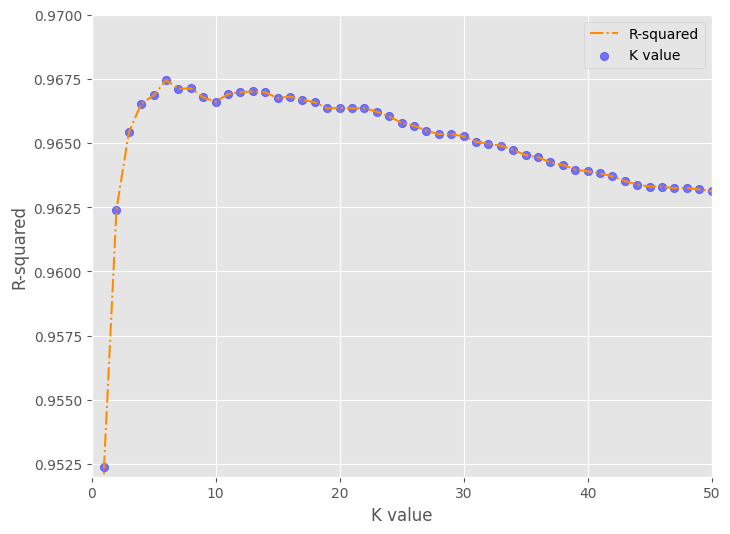

In [26]:
# Plot R-squared for each K value
r2_scores.insert(0, 0)
plt.figure(figsize=(8,6))
plt.plot(r2_scores, '-.', c='darkorange')
plt.scatter(range(0, 100), y=r2_scores, alpha=0.5, c='b')
plt.xlabel("K value")
plt.ylabel("R-squared")
plt.xlim(0, 50)
plt.ylim(0.9520,0.970)
plt.legend(['R-squared', 'K value']);

In [27]:
# As 6 seems to be the optimal value for K, let's train a new model with K=6 neighbors
knn = KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The R-squared for this model is " + str(round(r2, 4)) + ".")
print("The MSE for this model is " + str(int(mse)) + ".")

The R-squared for this model is 0.9675.
The MSE for this model is 518975.


In [28]:
# Get metrics for this model
metrics = [mse, r2]
table_index = ['MSE', 'R-Squared']

table = pd.DataFrame(metrics, index=table_index, columns=['Model Metrics'])
table

,Model Metrics
MSE,518975.785578
R-Squared,0.967453


In [29]:
# Let's build another set of KNN models using cross validation this time

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=12)
neighbors = range(1, 20)
scores = []
for i in neighbors:   # running for different K values to know which yields the maximum accuracy
    knn = KNeighborsRegressor(n_neighbors=i, weights='distance', p=1)
    knn.fit(X_train, y_train)
    score = cross_val_score(knn, X_train, y_train, cv=10)
    scores.append(score.mean())

In [30]:
# Compute the MSE for each model
mse = [1-x for x in scores]

# Find the optimal K value, corresponding to the model with the lowest MSE
optimal_k = neighbors[mse.index(min(mse))]
print('According to cross validation, the optimal value of K is:', optimal_k)

According to cross validation, the optimal value of K is: 11


In [31]:
# Training the model on K=11
clf_optimal = KNeighborsRegressor(n_neighbors = optimal_k)
clf_optimal.fit(X_train, y_train)
y_pred = clf_optimal.predict(X_val)
r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
print("The R-squared for this model is " + str(round(r2, 4)) + ".")
print("The MSE for this model is " + str(int(mse)) + ".")

The R-squared for this model is 0.9538.
The MSE for this model is 746699.


In [32]:
# Get metrics for this model
metrics = [mse, r2]
table_index = ['MSE', 'R-Squared']
table = pd.DataFrame(metrics, index=table_index, columns=['Model Metrics'])
table

,Model Metrics
MSE,746699.280077
R-Squared,0.953838


**Note:** Using cross validation gives us an optimal K value equal to 11. Here the R-squared is slightly lower and the MSE higher, but we can imagine that this model performs better on new and unseen data than our first model with K=6.